# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [37]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import math

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [5]:
"""opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())"""

"opener = urllib.request.URLopener()\nopener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)\ntar_file = tarfile.open(MODEL_FILE)\nfor file in tar_file.getmembers():\n  file_name = os.path.basename(file.name)\n  if 'frozen_inference_graph.pb' in file_name:\n    tar_file.extract(file, os.getcwd())"

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [59]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7)]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [52]:
def compressRate(np_image, const):
    cr =  math.sqrt(np_image.shape[0]*np_image.shape[1]/const)
    print(cr)
    return cr if cr>1 else 1

In [53]:
# 图片压缩批处理,第一个参数是路径，第二个参数是比例，压缩请使用小于1的参数
def compressImage(srcFile, scale):
        # 打开原图片缩小后保存，可以用if srcFile.endswith(".jpg")或者split，splitext等函数等针对特定文件压缩
        sImg = Image.open(srcFile)
        w, h = sImg.size
        dImg = sImg.resize((int(w / scale), int(h / scale)), Image.ANTIALIAS)
        pix = np.array(dImg)
        return pix


In [40]:
sess = tf.Session(graph=detection_graph)

2.5519874607842414
3.488266044899672
1.0627793750351011
2.4503061033266844
9.19185726608067
1.159310139695155


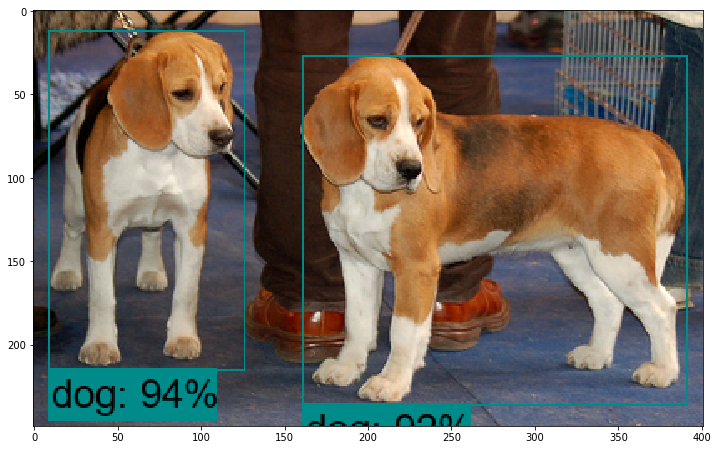

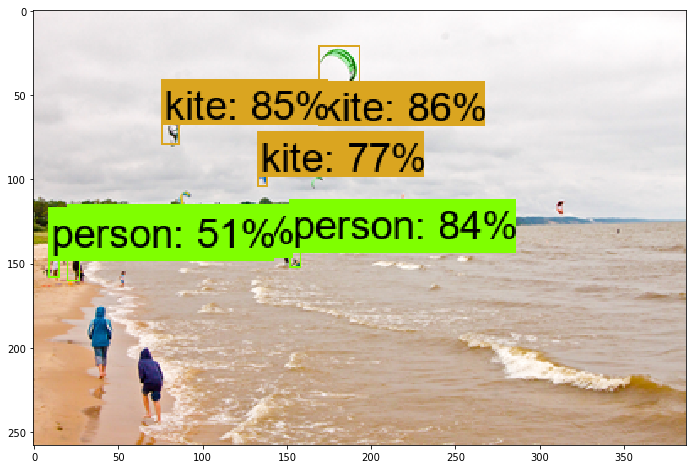

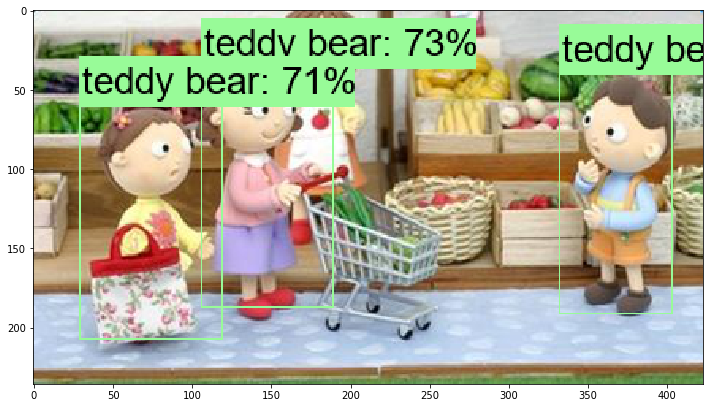

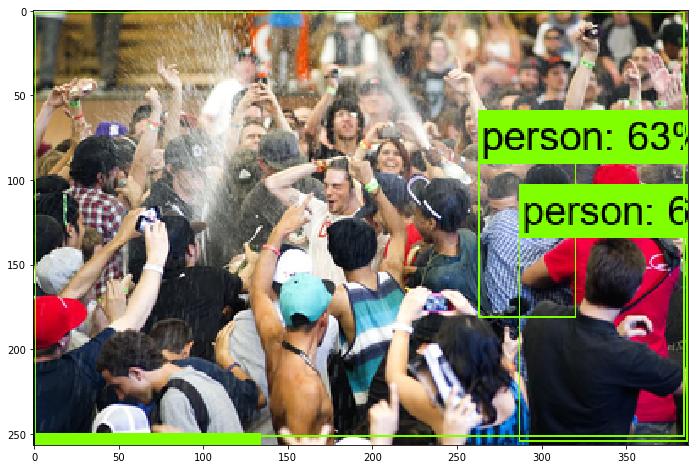

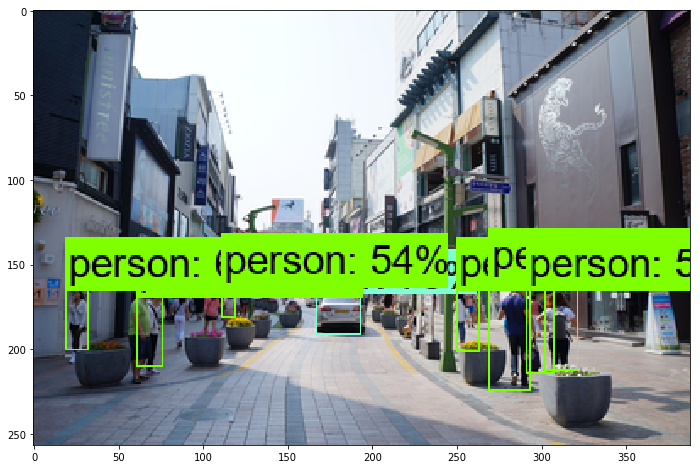

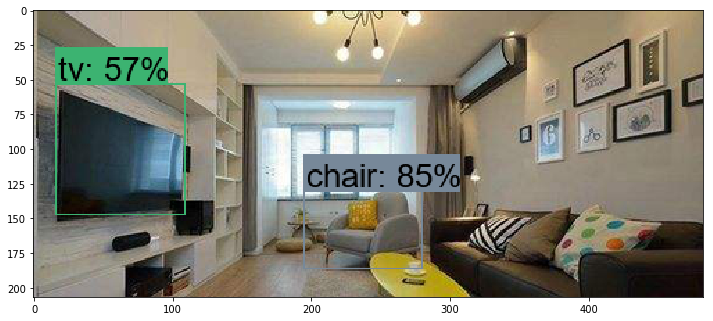

In [63]:
with detection_graph.as_default():  
    for image_path in TEST_IMAGE_PATHS:  
      image = Image.open(image_path)  
      # 这个array在之后会被用来准备为图片加上框和标签  
      image_np = load_image_into_numpy_array(image)  
      image_np = compressImage(image_path, compressRate(image_np, 100000))
      # 扩展维度，应为模型期待: [1, None, None, 3]  
      image_np_expanded = np.expand_dims(image_np, axis=0)  
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')  
      # 每个框代表一个物体被侦测到.  
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')  
      # 每个分值代表侦测到物体的可信度.  
      scores = detection_graph.get_tensor_by_name('detection_scores:0')  
      classes = detection_graph.get_tensor_by_name('detection_classes:0')  
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')  
      # 执行侦测任务.  
      (boxes, scores, classes, num_detections) = sess.run(  
          [boxes, scores, classes, num_detections],  
          feed_dict={image_tensor: image_np_expanded})  
      # 图形化.  
      vis_util.visualize_boxes_and_labels_on_image_array(  
          image_np,  
          np.squeeze(boxes),  
          np.squeeze(classes).astype(np.int32),  
          np.squeeze(scores),  
          category_index,  
          use_normalized_coordinates=True,  
          line_thickness=1)
      plt.figure(figsize=IMAGE_SIZE)  
      plt.imshow(image_np)